## 2570 Proj 3
___Warren Shi___

In [1]:
## Set up 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

%matplotlib inline

### Q1 

### a). simulation function

In [2]:
## i) function for simulation
'''
Function sim_wt
This function takes the intensity parameter alpha and number of simulations n to simulate n iid wait times for 
a Poisson Process with intensity alpha. 

parameters:
    alpha: double, the intensity parameter
    n    : double, number of simulations 
    
output:
    np array of length n, the n simulated wait times
'''
def sim_wt(n, alpha = 3):
    return -np.log(1 - np.random.uniform(0,1,n)) / alpha

In [3]:
## ii) find N
# we find the variance first from the pilot study
pilot_size = 150
pilot_data = sim_wt(pilot_size)
pilot_var = np.var(pilot_data)
z = st.norm.ppf(0.995)
target_N = int(np.ceil((z*np.sqrt(pilot_var)/0.01)**2))

In [4]:
str(target_N)

'7591'

In [5]:
## iii) find CI
wt_sample = sim_wt(target_N)
e_wt = np.mean(wt_sample)
se_wt = np.sqrt(np.var(wt_sample)/target_N)
CI_lower, CI_upper = e_wt - z * se_wt, e_wt + z * se_wt

In [6]:
print('The required sample size for the CI is: ' + str(target_N)) 
print('The estimated expect value of Wt is   : ' + str(e_wt)) 
print('The 99% confidence interval is        : ' + str((CI_lower, CI_upper))) 

The required sample size for the CI is: 7591
The estimated expect value of Wt is   : 0.33407002335353153
The 99% confidence interval is        : (0.3242744931426115, 0.3438655535644516)


### b). acceptance-rejection

In [7]:
def pdf_1b(x, alpha = 3, t = 1):
    if np.isscalar(x):
        x = np.array(x)
    arr1 = np.where((x<=t) & (x>0), alpha**2 * x * np.exp(-alpha*x), 0)
    arr2 = np.where(x>t, alpha * (1 + alpha * t) * np.exp(-alpha*x), 0)
    return arr1 + arr2

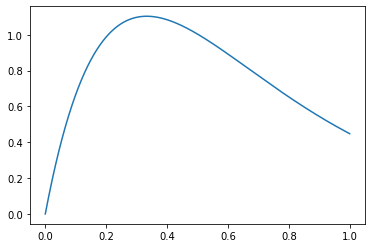

In [10]:
x = np.linspace(0,1,10000)
plt.plot(x, pdf_1b(x))

In [9]:
import scipy.integrate as integrate
integrate.quad(pdf_1b, 0, 7454)

(7.471750752074412e-09, 1.48561220773963e-08)

In [11]:
3/np.e

1.103638323514327

In [12]:
12/np.e**3

0.5974448204143674